In [1]:
!pip -q install rouge-score

import os
import re
import json
import math
import time
import random
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}, device: {device}")

  Preparing metadata (setup.py) ... done
PyTorch: 2.8.0+cu126, device: cuda


In [2]:
# Data
FILE_NAME = 'news_summary_more.csv'
NUM_SAMPLES = 60000  # cap for faster iteration

# Model
EMBEDDING_DIM = 256
ENCODER_HID_DIM = 256
DECODER_HID_DIM = 512  # should be 2 * ENCODER_HID_DIM if using bi-LSTM + linear projection
ENC_NUM_LAYERS = 1
DEC_NUM_LAYERS = 1
DROPOUT = 0.3

# Training
BATCH_SIZE = 64
N_EPOCHS = 15
CLIP = 1.0
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1  # will fallback if torch version < 1.10
TEACHER_FORCING_START = 1.0
TEACHER_FORCING_END = 0.2

# Length caps
MAX_SRC_LEN = 400
MAX_TRG_LEN = 50

# Load dataset
try:
    df = pd.read_csv(FILE_NAME)
    print(f"Loaded: {FILE_NAME} with {len(df)} rows")
except FileNotFoundError:
    raise FileNotFoundError(f"{FILE_NAME} not found. Please upload it.")

df = df[['text', 'headlines']].dropna()
df = df.iloc[:NUM_SAMPLES].copy()
print(f"Using {len(df)} samples")

Loaded: news_summary_more.csv with 98401 rows
Using 60000 samples


In [3]:
# Contractions (same as you had; truncated for brevity — keep full mapping if you like)
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'll": "it will", "it's": "it is", "let's": "let us", "ma'am": "madam", "mustn't": "must not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have",
    "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what's": "what is", "where's": "where is", "who's": "who is", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have"
}

def preprocess_text(text: str) -> str:
    text = str(text).lower()
    # Tokenize into words and keep common punctuation
    tokens = re.findall(r"[a-z0-9]+|[.,!?;:()\-\'\"]", text)
    # Expand contractions
    expanded = []
    for tok in tokens:
        if tok in contractions:
            expanded.extend(contractions[tok].split())
        else:
            expanded.append(tok)
    # Join and clean spaces
    text = ' '.join(expanded)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(preprocess_text)
df['clean_summary'] = df['headlines'].apply(preprocess_text)

print("--- Example ---")
print("Article:", df['clean_text'].iloc[0][:200], "...")
print("Summary:", df['clean_summary'].iloc[0])

--- Example ---
Article: saurav kant , an alumnus of upgrad and iiit - b ' s pg program in machine learning and artificial intelligence , was a sr systems engineer at infosys with almost 5 years of work experience . the progr ...
Summary: upgrad learner switches to career in ml al with 90 salary hike


In [4]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=SEED, shuffle=True)
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

Train: 54000, Val: 6000


In [5]:
class Vocab:
    def __init__(self, texts, min_freq=3, max_size=50000, specials=None):
        if specials is None:
            specials = ['<unk>', '<pad>', '<start>', '<end>']
        self.specials = specials

        counter = Counter()
        for t in texts:
            counter.update(t.split())

        # reserve space for specials
        most_common = counter.most_common()
        # filter by min_freq
        most_common = [item for item in most_common if item[1] >= min_freq]
        # cap to max_size - specials
        most_common = most_common[:max_size - len(specials)]

        self.stoi = {tok: idx for idx, tok in enumerate(specials)}
        for word, _ in most_common:
            if word not in self.stoi:
                self.stoi[word] = len(self.stoi)

        self.itos = {i: s for s, i in self.stoi.items()}

        self.unk_idx = self.stoi['<unk>']
        self.pad_idx = self.stoi['<pad>']
        self.start_idx = self.stoi['<start>']
        self.end_idx = self.stoi['<end>']

    def __len__(self):
        return len(self.stoi)

    def text_to_sequence(self, text):
        return [self.stoi.get(tok, self.unk_idx) for tok in text.split()]

    def sequence_to_text(self, seq):
        return ' '.join([self.itos.get(i, '<unk>') for i in seq])

# Build vocab from TRAIN ONLY to avoid leakage
train_texts = (train_df['clean_text'].tolist() + train_df['clean_summary'].tolist())
vocab = Vocab(train_texts, min_freq=3, max_size=50000)
PAD_IDX = vocab.pad_idx
print(f"Vocab size: {len(vocab)} | PAD_IDX={PAD_IDX} START={vocab.start_idx} END={vocab.end_idx}")

Vocab size: 33127 | PAD_IDX=1 START=2 END=3


In [6]:
class ArticleSummaryDataset(Dataset):
    def __init__(self, df, vocab, max_src_len=400, max_trg_len=50):
        self.articles = df['clean_text'].tolist()
        self.summaries = df['clean_summary'].tolist()
        self.vocab = vocab
        self.max_src_len = max_src_len
        self.max_trg_len = max_trg_len

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        src_tokens = self.articles[idx].split()
        trg_tokens = self.summaries[idx].split()

        # Truncate
        src_tokens = src_tokens[:self.max_src_len]
        # reserve room for <start> and <end>
        trg_tokens = trg_tokens[:self.max_trg_len - 2]

        # Add special tokens
        trg_tokens = ['<start>'] + trg_tokens + ['<end>']

        src_ids = torch.tensor(self.vocab.text_to_sequence(' '.join(src_tokens)), dtype=torch.long)
        trg_ids = torch.tensor(self.vocab.text_to_sequence(' '.join(trg_tokens)), dtype=torch.long)

        return src_ids, trg_ids

def collate_fn(batch):
    src_list, trg_list = zip(*batch)
    src_lengths = torch.tensor([len(s) for s in src_list], dtype=torch.long)
    trg_lengths = torch.tensor([len(t) for t in trg_list], dtype=torch.long)
    src_padded = pad_sequence(src_list, batch_first=True, padding_value=PAD_IDX)
    trg_padded = pad_sequence(trg_list, batch_first=True, padding_value=PAD_IDX)
    return src_padded, src_lengths, trg_padded, trg_lengths

train_dataset = ArticleSummaryDataset(train_df, vocab, MAX_SRC_LEN, MAX_TRG_LEN)
val_dataset   = ArticleSummaryDataset(val_df, vocab, MAX_SRC_LEN, MAX_TRG_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 844, Val batches: 94


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, num_layers=1, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            emb_dim,
            enc_hid_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        # Project concatenated hidden state to decoder hidden dim
        self.fc_hidden = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.fc_cell   = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

    def forward(self, src, src_lengths):
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_outputs, (hidden, cell) = self.lstm(packed)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)
        # outputs: [batch, src_len, enc_hid_dim * 2]
        # hidden: [num_layers*2, batch, enc_hid_dim]
        # Concatenate last forward and backward
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        cell_cat   = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)
        hidden = torch.tanh(self.fc_hidden(hidden_cat)).unsqueeze(0)  # [1, batch, dec_hid_dim]
        cell   = torch.tanh(self.fc_cell(cell_cat)).unsqueeze(0)      # [1, batch, dec_hid_dim]
        return outputs, (hidden, cell)

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.W_enc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.W_dec = nn.Linear(dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, dec_hidden, enc_outputs, mask):
        # dec_hidden: [batch, dec_hid_dim]
        # enc_outputs: [batch, src_len, enc_hid_dim*2]
        # mask: [batch, src_len] (True for tokens, False for PAD)
        energy = torch.tanh(self.W_enc(enc_outputs) + self.W_dec(dec_hidden).unsqueeze(1))
        scores = self.v(energy).squeeze(2)  # [batch, src_len]

        scores = scores.masked_fill(~mask, -1e9)
        attn = F.softmax(scores, dim=1)     # [batch, src_len]
        return attn

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, num_layers=1, dropout=0.3, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.attention = BahdanauAttention(enc_hid_dim, dec_hid_dim)
        self.lstm = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim, num_layers=num_layers, batch_first=True)
        # Use context + current output + embedding for projection
        self.fc_out = nn.Linear(dec_hid_dim + (enc_hid_dim * 2) + emb_dim, output_dim)

    def forward(self, input, hidden, cell, enc_outputs, mask):
        # input: [batch]
        emb = self.dropout(self.embedding(input)).unsqueeze(1)   # [batch, 1, emb_dim]
        dec_hidden = hidden[-1]                                  # [batch, dec_hid_dim]
        attn = self.attention(dec_hidden, enc_outputs, mask)     # [batch, src_len]
        context = torch.bmm(attn.unsqueeze(1), enc_outputs)      # [batch, 1, enc_hid_dim*2]

        lstm_input = torch.cat([emb, context], dim=2)            # [batch, 1, emb_dim + enc*2]
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # output: [batch, 1, dec_hid_dim]
        output = output.squeeze(1)
        context = context.squeeze(1)
        emb = emb.squeeze(1)

        logits = self.fc_out(torch.cat([output, context, emb], dim=1))  # [batch, output_dim]
        return logits, (hidden, cell), attn

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx

    def make_src_mask(self, src):
        # True for tokens, False for PAD
        return (src != self.pad_idx)

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=src.device)

        enc_outputs, (hidden, cell) = self.encoder(src, src_lengths)
        mask = self.make_src_mask(src)  # [batch, src_len]

        input = trg[:, 0]  # <start>
        for t in range(1, trg_len):
            logits, (hidden, cell), _ = self.decoder(input, hidden, cell, enc_outputs, mask)
            outputs[:, t, :] = logits
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = logits.argmax(dim=1)
            input = trg[:, t] if teacher_force else top1

        return outputs

In [8]:
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)

encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, ENCODER_HID_DIM, DECODER_HID_DIM, ENC_NUM_LAYERS, DROPOUT, PAD_IDX).to(device)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, ENCODER_HID_DIM, DECODER_HID_DIM, DEC_NUM_LAYERS, DROPOUT, PAD_IDX).to(device)
model = Seq2Seq(encoder, decoder, PAD_IDX).to(device)

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Embedding)):
        nn.init.xavier_uniform_(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.)
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

model.apply(init_weights)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Label smoothing (fallback if not supported)
try:
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=LABEL_SMOOTHING).to(device)
    print("Using CrossEntropyLoss with label smoothing")
except TypeError:
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(device)
    print("Using CrossEntropyLoss without label smoothing (older PyTorch)")

# Reduce LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Using CrossEntropyLoss with label smoothing
Trainable params: 64,126,055


In [9]:
def train_step(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0.0

    for src, src_lengths, trg, trg_lengths in iterator:
        src, src_lengths, trg = src.to(device), src_lengths.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, src_lengths, trg, teacher_forcing_ratio)  # [batch, trg_len, vocab]
        output_dim = output.shape[-1]
        # Skip t=0 (the <start> token)
        logits = output[:, 1:, :].reshape(-1, output_dim)
        targets = trg[:, 1:].reshape(-1)

        loss = criterion(logits, targets)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

@torch.no_grad()
def validation_step(model, iterator, criterion):
    model.eval()
    epoch_loss = 0.0

    for src, src_lengths, trg, trg_lengths in iterator:
        src, src_lengths, trg = src.to(device), src_lengths.to(device), trg.to(device)

        output = model(src, src_lengths, trg, teacher_forcing_ratio=0.0)
        output_dim = output.shape[-1]
        logits = output[:, 1:, :].reshape(-1, output_dim)
        targets = trg[:, 1:].reshape(-1)

        loss = criterion(logits, targets)
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

--- Training for 15 epochs ---
Epoch 01/15 | 4m16s | TFR=1.00 | Train 7.2967 | Val 8.5615 | LR 3.00e-04
Epoch 02/15 | 4m21s | TFR=0.94 | Train 6.6247 | Val 7.9439 | LR 3.00e-04
Epoch 03/15 | 4m21s | TFR=0.89 | Train 6.2556 | Val 7.5903 | LR 3.00e-04
Epoch 04/15 | 4m22s | TFR=0.83 | Train 6.0221 | Val 7.4157 | LR 3.00e-04
Epoch 05/15 | 4m21s | TFR=0.77 | Train 5.8568 | Val 7.2583 | LR 3.00e-04
Epoch 06/15 | 4m21s | TFR=0.71 | Train 5.7105 | Val 7.1004 | LR 3.00e-04
Epoch 07/15 | 4m22s | TFR=0.66 | Train 5.6102 | Val 6.9922 | LR 3.00e-04
Epoch 08/15 | 4m21s | TFR=0.60 | Train 5.5116 | Val 6.8586 | LR 3.00e-04
Epoch 09/15 | 4m21s | TFR=0.54 | Train 5.4271 | Val 6.7730 | LR 3.00e-04
Epoch 10/15 | 4m22s | TFR=0.49 | Train 5.3582 | Val 6.6820 | LR 3.00e-04
Epoch 11/15 | 4m21s | TFR=0.43 | Train 5.2828 | Val 6.6257 | LR 3.00e-04
Epoch 12/15 | 4m22s | TFR=0.37 | Train 5.2111 | Val 6.5733 | LR 3.00e-04
Epoch 13/15 | 4m21s | TFR=0.31 | Train 5.1340 | Val 6.5355 | LR 3.00e-04
Epoch 14/15 | 4m21s 

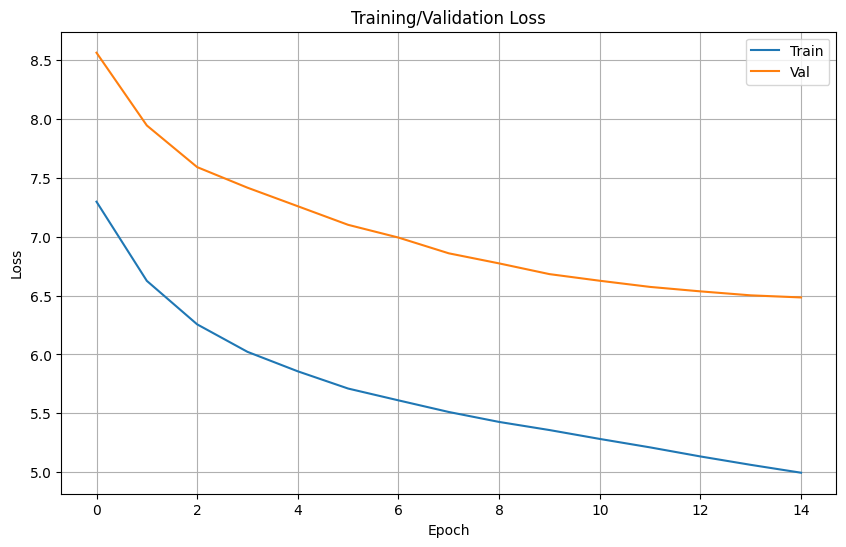

In [10]:
best_val = float('inf')
patience = 4
stalled = 0

train_loss_history, val_loss_history = [], []

def schedule_teacher_forcing(epoch, total_epochs, start=1.0, end=0.2):
    # Linear decay
    ratio = start + (end - start) * (epoch / (total_epochs - 1))
    return max(min(ratio, start), end)

print(f"--- Training for {N_EPOCHS} epochs ---")
for epoch in range(N_EPOCHS):
    start_time = time.time()

    tfr = schedule_teacher_forcing(epoch, N_EPOCHS, TEACHER_FORCING_START, TEACHER_FORCING_END)
    train_loss = train_step(model, train_loader, optimizer, criterion, CLIP, tfr)
    val_loss = validation_step(model, val_loader, criterion)

    scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1:02}/{N_EPOCHS} | {int(elapsed//60)}m{int(elapsed%60)}s "
          f"| TFR={tfr:.2f} | Train {train_loss:.4f} | Val {val_loss:.4f} | LR {optimizer.param_groups[0]['lr']:.2e}")

    # Early stopping
    if val_loss < best_val - 1e-4:
        best_val = val_loss
        stalled = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        stalled += 1
        if stalled >= patience:
            print("Early stopping triggered.")
            break

print("Training done.")

# Plot curves
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_pytorch.png')
plt.show()

In [11]:
@torch.no_grad()
def summarize_greedy(model, sentence, vocab, device, max_len=30):
    model.eval()
    clean_text = preprocess_text(sentence)
    src_ids = vocab.text_to_sequence(' '.join(clean_text.split()[:MAX_SRC_LEN]))
    src_tensor = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)
    src_lengths = torch.tensor([len(src_ids)], dtype=torch.long).to(device)

    enc_outputs, (hidden, cell) = model.encoder(src_tensor, src_lengths)
    mask = model.make_src_mask(src_tensor)

    input_id = torch.tensor([vocab.start_idx], dtype=torch.long, device=device)
    generated_ids = [vocab.start_idx]
    attentions = []

    for _ in range(max_len):
        logits, (hidden, cell), attn = model.decoder(input_id, hidden, cell, enc_outputs, mask)
        pred_id = logits.argmax(dim=-1).item()
        generated_ids.append(pred_id)
        attentions.append(attn.squeeze(0).cpu().numpy())
        if pred_id == vocab.end_idx:
            break
        input_id = torch.tensor([pred_id], dtype=torch.long, device=device)

    tokens = [vocab.itos.get(i, '<unk>') for i in generated_ids[1:]]
    summary = ' '.join(tokens).replace(' <end>', '').strip()
    return summary, clean_text.split(), np.stack(attentions, axis=0) if attentions else np.zeros((0, len(src_ids)))

@torch.no_grad()
def summarize_beam(model, sentence, vocab, device, max_len=30, beam_size=4, len_penalty=0.7):
    model.eval()
    clean_text = preprocess_text(sentence)
    src_ids = vocab.text_to_sequence(' '.join(clean_text.split()[:MAX_SRC_LEN]))
    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)
    src_lengths = torch.tensor([len(src_ids)], dtype=torch.long).to(device)

    enc_outputs, (hidden, cell) = model.encoder(src, src_lengths)
    mask = model.make_src_mask(src)

    # beam: list of (log_prob, ids, hidden, cell)
    beams = [(0.0, [vocab.start_idx], hidden, cell)]
    completed = []

    for _ in range(max_len):
        new_beams = []
        for logp, ids, h, c in beams:
            last_id = ids[-1]
            if last_id == vocab.end_idx:
                completed.append((logp, ids))
                continue
            inp = torch.tensor([last_id], dtype=torch.long, device=device)
            logits, (h_new, c_new), _ = model.decoder(inp, h, c, enc_outputs, mask)
            log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # [vocab]
            topk_logp, topk_idx = torch.topk(log_probs, beam_size)

            for k in range(beam_size):
                new_logp = logp + topk_logp[k].item()
                new_ids = ids + [topk_idx[k].item()]
                new_beams.append((new_logp, new_ids, h_new, c_new))

        # keep top beams
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]

        # if all beams ended
        if all(b[1][-1] == vocab.end_idx for b in beams):
            completed.extend([(b[0], b[1]) for b in beams])
            break

    if not completed:
        completed = [(b[0], b[1]) for b in beams]

    # length penalty: lp = ((5+len)^len_penalty)/(6^len_penalty)
    def norm_score(logp, ids):
        L = max(1, len(ids)-1)  # exclude start
        lp = ((5 + L) ** len_penalty) / ((6) ** len_penalty)
        return logp / lp

    best = max(completed, key=lambda x: norm_score(x[0], x[1]))
    pred_ids = best[1][1:]  # drop <start>
    # truncate at <end>
    if vocab.end_idx in pred_ids:
        pred_ids = pred_ids[:pred_ids.index(vocab.end_idx)]

    tokens = [vocab.itos.get(i, '<unk>') for i in pred_ids]
    summary = ' '.join(tokens)
    return summary

def plot_attention(text_to_summarize):
    pred, orig_words, attn = summarize_greedy(model, text_to_summarize, vocab, device, max_len=MAX_TRG_LEN)
    if attn.shape[0] == 0:
        print("No attention collected (very short decode).")
        return

    attn = attn[:min(len(pred.split()), attn.shape[0]), :min(len(orig_words), attn.shape[1])]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attn, cmap='viridis')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + orig_words, rotation=90)
    ax.set_yticklabels([''] + pred.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Input Article Words')
    plt.ylabel('Predicted Summary Words')
    plt.title('Attention Heatmap')
    plt.tight_layout()
    plt.savefig('attention_plot_pytorch.png')
    plt.show()

    print("\nOriginal:")
    print(text_to_summarize[:500], "...")
    print("\nPredicted summary:")
    print(pred)

In [12]:
from rouge_score import rouge_scorer

@torch.no_grad()
def calculate_rouge_scores(num_samples=100, use_beam=True):
    print(f"\n--- Calculating ROUGE for {num_samples} random val samples ---")
    sample_df = val_df.sample(n=min(num_samples, len(val_df)), random_state=SEED)
    real_summaries = sample_df['headlines'].tolist()
    real_articles = sample_df['text'].tolist()

    preds = []
    for art in real_articles:
        if use_beam:
            pred = summarize_beam(model, art, vocab, device, max_len=MAX_TRG_LEN, beam_size=4)
        else:
            pred, _, _ = summarize_greedy(model, art, vocab, device, max_len=MAX_TRG_LEN)
        preds.append(pred)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    r1, r2, rL = [], [], []
    for ref, hyp in zip(real_summaries, preds):
        scores = scorer.score(ref, hyp)
        r1.append(scores['rouge1'].fmeasure)
        r2.append(scores['rouge2'].fmeasure)
        rL.append(scores['rougeL'].fmeasure)

    print(f"ROUGE-1 F1: {np.mean(r1):.4f}")
    print(f"ROUGE-2 F1: {np.mean(r2):.4f}")
    print(f"ROUGE-L F1: {np.mean(rL):.4f}")

calculate_rouge_scores(num_samples=100, use_beam=True)


--- Calculating ROUGE for 100 random val samples ---
ROUGE-1 F1: 0.2068
ROUGE-2 F1: 0.0446
ROUGE-L F1: 0.1926


--- Quick test ---
Beam summary: india to australia australia for australia cricket in australia


/tmp/ipython-input-922707000.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + orig_words, rotation=90)
/tmp/ipython-input-922707000.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + pred.split())


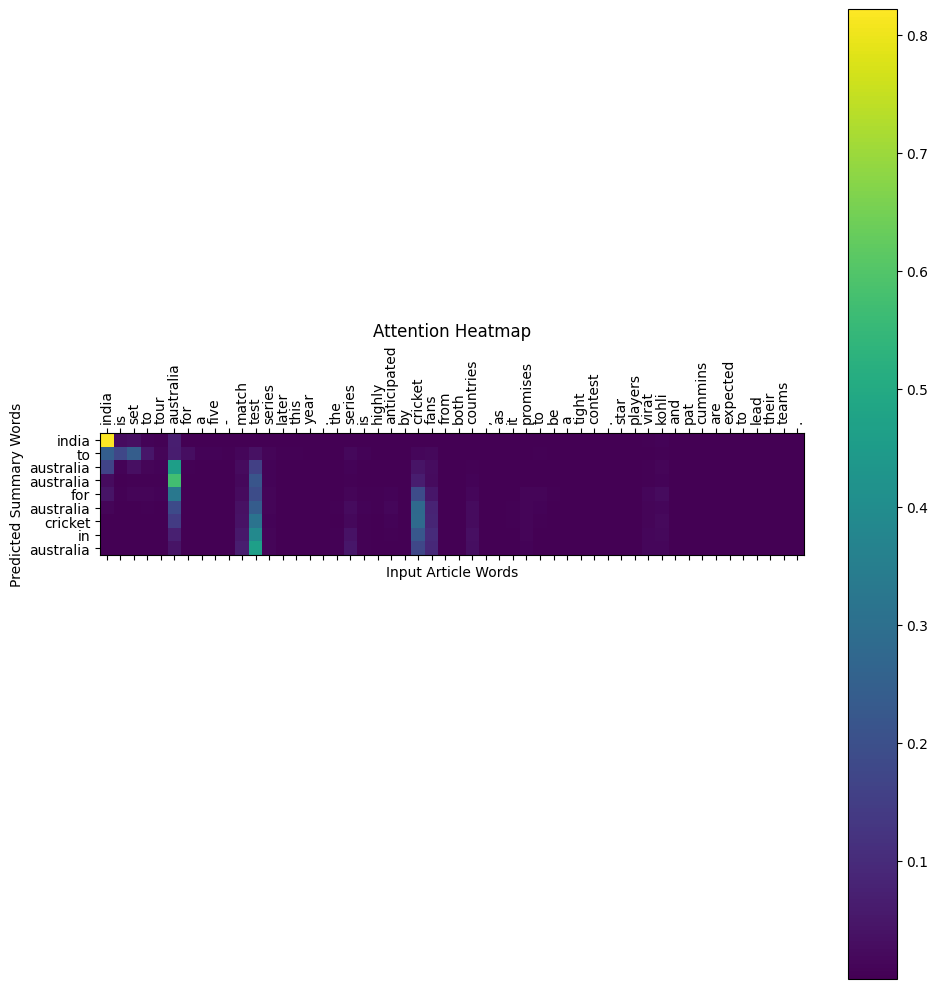


Original:
India is set to tour Australia for a five-match test series later this year. The series is highly anticipated by cricket fans from both countries, as it promises to be a tight contest. Star players Virat Kohli and Pat Cummins are expected to lead their teams. ...

Predicted summary:
india to australia australia for australia cricket in australia


In [13]:
print("--- Quick test ---")
custom_text = "India is set to tour Australia for a five-match test series later this year. \
The series is highly anticipated by cricket fans from both countries, as it promises to be a tight contest. \
Star players Virat Kohli and Pat Cummins are expected to lead their teams."

# Beam for final output
pred_beam = summarize_beam(model, custom_text, vocab, device, max_len=MAX_TRG_LEN, beam_size=4)
print("Beam summary:", pred_beam)

# Greedy + attention plot
plot_attention(custom_text)

In [14]:
# Reload best (in case of early stopping)
if os.path.exists('best_model.pt'):
    model.load_state_dict(torch.load('best_model.pt', map_location=device))
    print("Loaded best_model.pt")

model_path = 'summarizer_model.pt'
torch.save(model.state_dict(), model_path)
print(f"Saved weights to {model_path}")

tokenizer_path = 'tokenizer.json'
tokenizer_data = {
    'stoi': vocab.stoi,
    'specials': vocab.specials,
    'pad_idx': vocab.pad_idx,
    'unk_idx': vocab.unk_idx,
    'start_idx': vocab.start_idx,
    'end_idx': vocab.end_idx,
    'max_src_len': MAX_SRC_LEN,
    'max_trg_len': MAX_TRG_LEN
}
with open(tokenizer_path, 'w', encoding='utf-8') as f:
    json.dump(tokenizer_data, f, ensure_ascii=False, indent=2)
print(f"Saved vocab to {tokenizer_path}")

# Zip and download (Colab)
zip_file_name = 'pytorch_summarizer.zip'
if os.path.exists(zip_file_name):
    os.remove(zip_file_name)

!zip -q {zip_file_name} {model_path} {tokenizer_path}
from google.colab import files
files.download(zip_file_name)
print(f"Zipped and downloaded {zip_file_name}")

Loaded best_model.pt
Saved weights to summarizer_model.pt
Saved vocab to tokenizer.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zipped and downloaded pytorch_summarizer.zip


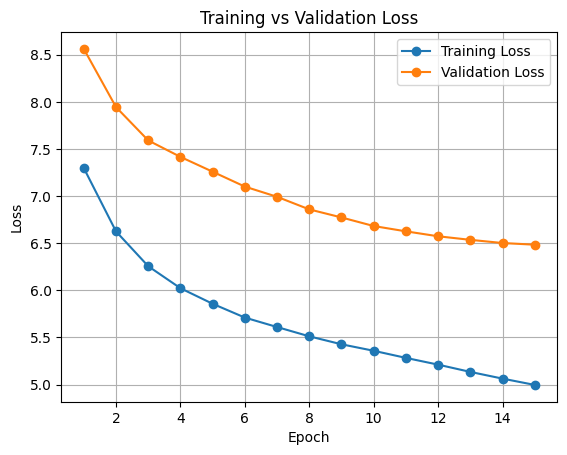

In [1]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 16))
train_loss = [7.2967, 6.6247, 6.2556, 6.0221, 5.8568, 5.7105, 5.6102, 5.5116, 5.4271, 5.3582, 5.2828, 5.2111, 5.1340, 5.0628, 4.9959]
val_loss = [8.5615, 7.9439, 7.5903, 7.4157, 7.2583, 7.1004, 6.9922, 6.8586, 6.7730, 6.6820, 6.6257, 6.5733, 6.5355, 6.5017, 6.4839]

# Plot
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
